In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [14]:
def homogeneous(R, p):
    M = np.eye(4)
    M[:3,:3] = R
    M[:3,3] = p.flatten()
    return M

def transform_point_homogeneous(T, p):
    # p: 3x1 column vector or 3 element array
    p_col = p.reshape(3,1)
    v = np.vstack((p_col, np.array([[1.0]])))
    w = T @ v
    return w[:3,0] # Return flat array

# --- ΤΡΟΠΟΠΟΙΗΣΗ ΕΔΩ: Χρήση ax.quiver αντί για ax.plot ---
def plot_frame(ax, T, size=2.0, linewidth=1.5):
    # size in cm for plotting
    p = T[:3,3]    # Origin points
    R = T[:3,:3]   # Rotation matrix (columns are X, Y, Z axes)

    # X-axis (Red)
    ax.quiver(p[0], p[1], p[2], R[0,0], R[1,0], R[2,0],
              length=size, color='r', normalize=True, linewidth=linewidth)

    # Y-axis (Green)
    ax.quiver(p[0], p[1], p[2], R[0,1], R[1,1], R[2,1],
              length=size, color='g', normalize=True, linewidth=linewidth)

    # Z-axis (Blue)
    ax.quiver(p[0], p[1], p[2], R[0,2], R[1,2], R[2,2],
              length=size, color='b', normalize=True, linewidth=linewidth)

# Rotation helpers
def RotX(t):
    c = np.cos(t); s = np.sin(t)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]])
def RotY(t):
    c = np.cos(t); s = np.sin(t)
    return np.array([[c,0,s],[0,1,0],[-s,0,c]])
def RotZ(t):
    c = np.cos(t); s = np.sin(t)
    return np.array([[c,-s,0],[s,c,0],[0,0,1]])

In [15]:
# --- Robot Parameters ---
d1 = 169.5 / 1000.0
d3 = 115.5 / 1000.0
d5 = 127.83 / 1000.0
d7 = 65.98 / 1000.0

def skew(w):
    return np.array([[0,-w[2], w[1]],[w[2],0,-w[0]],[-w[1],w[0],0]])

def screw_axis(w, q):
    v = -np.cross(w, q)
    return np.hstack((w, v))

def matrix_exp6(xi):
    w = xi[:3].astype(float)
    v = xi[3:].astype(float)
    theta = np.linalg.norm(w)
    if theta < 1e-9:
        T_mat = np.eye(4)
        T_mat[:3,3] = v
        return T_mat
    w_unit = w/theta
    w_hat = skew(w_unit)
    R = np.eye(3) + math.sin(theta)*w_hat + (1-math.cos(theta))*(w_hat @ w_hat)
    G = np.eye(3)*theta + (1-math.cos(theta))*w_hat + (theta-math.sin(theta))*(w_hat @ w_hat)
    p = (G @ v) / theta
    T_mat = np.eye(4)
    T_mat[:3,:3] = R
    T_mat[:3,3] = p
    return T_mat

In [16]:
# axes & q positions
w1 = np.array([0., 0., 1.])
w2 = np.array([0., 1., 0.])
w3 = np.array([0., 0., 1.])
w4 = np.array([1., 0., 0.])
w5 = np.array([0., 0., 1.])
w6 = np.array([1., 0., 0.])
w7 = np.array([0., 0., 1.])

q1 = np.array([0.0, 0.0, 0.0])
q2 = np.array([0.0, 0.0, d1])
q3 = np.array([0.0, 0.0, d1 + d3])
q4 = np.array([0.0, 0.0, d1 + d3])
q5 = np.array([0.0, 0.0, d1 + d3 + d5])
q6 = np.array([0.0, 0.0, d1 + d3 + d5])
q7 = np.array([0.0, 0.0, d1 + d3 + d5 + d7])

S1 = screw_axis(w1, q1)
S2 = screw_axis(w2, q2)
S3 = screw_axis(w3, q3)
S4 = screw_axis(w4, q4)
S5 = screw_axis(w5, q5)
S6 = screw_axis(w6, q6)
S7 = screw_axis(w7, q7)
Screw_axis = np.column_stack((S1, S2, S3, S4, S5, S6, S7))

jlim = np.deg2rad(np.array([
    [-160.0, 160.0], [-70.0, 115.0], [-170.0, 170.0],
    [-113.0, 75.0], [-170.0, 170.0], [-115.0, 115.0], [-180.0, 180.0]
]))

In [17]:
def fk_poe(S_list, M, theta):
    T_mat = np.eye(4)
    for i in range(S_list.shape[1]):
        T_mat = T_mat @ matrix_exp6(S_list[:, i] * theta[i])
    return T_mat @ M

def space_jacobian(q, S_list, M=None):
    Js = np.zeros((6, 7))
    Js[:, 0] = S_list[:, 0]
    T_mat = matrix_exp6(S_list[:, 0] * q[0])
    Js[:, 1] = np.linalg.multi_dot([adjoint(T_mat), S_list[:, 1]])
    T_mat = T_mat @ matrix_exp6(S_list[:, 1] * q[1])
    Js[:, 2] = adjoint(T_mat) @ S_list[:, 2]
    T_mat = T_mat @ matrix_exp6(S_list[:, 2] * q[2])
    Js[:, 3] = adjoint(T_mat) @ S_list[:, 3]
    T_mat = T_mat @ matrix_exp6(S_list[:, 3] * q[3])
    Js[:, 4] = adjoint(T_mat) @ S_list[:, 4]
    T_mat = T_mat @ matrix_exp6(S_list[:, 4] * q[4])
    Js[:, 5] = adjoint(T_mat) @ S_list[:, 5]
    T_mat = T_mat @ matrix_exp6(S_list[:, 5] * q[5])
    Js[:, 6] = adjoint(T_mat) @ S_list[:, 6]
    return Js

def adjoint(T_mat):
    R = T_mat[:3,:3]
    p = T_mat[:3,3]
    p_skew = skew(p)
    return np.block([[R, np.zeros((3,3))],[p_skew @ R, R]])

def so3_log(R):
    cos_theta = (np.trace(R) - 1) / 2.0
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    if abs(theta) < 1e-8:
        return np.zeros(3), 0.0
    w_hat = (R - R.T) / (2.0 * np.sin(theta))
    w = np.array([w_hat[2,1], w_hat[0,2], w_hat[1,0]])
    return w, theta

def se3_log(T_mat):
    R = T_mat[:3,:3]
    p = T_mat[:3,3]
    w, theta = so3_log(R)
    if abs(theta) < 1e-8:
        return np.hstack((np.zeros(3), p))
    w_hat = skew(w)
    A_inv = (np.eye(3)/theta - 0.5*w_hat + (1.0/theta - 0.5/np.tan(theta/2.0))*(w_hat @ w_hat))
    v = A_inv @ p
    return np.hstack((w*theta, v*theta))

def project_to_joint_limits(q, dq, limits):
    q = np.asarray(q, dtype=float)
    dq = np.asarray(dq, dtype=float)
    q_next = q + dq
    lower = limits[:, 0]
    upper = limits[:, 1]
    q_next_clipped = np.clip(q_next, lower, upper)
    new_dq = q_next_clipped - q
    return new_dq

In [18]:
def inverse_kinematics_space_basic(T_target, q0, M, joint_limits,
                                   max_iters=200, tol=1e-4, verbose=False):
    q = np.array(q0, dtype=float).copy()
    for k in range(max_iters):
        T_current = fk_poe(Screw_axis, M, q)
        T_diff = T_target @ np.linalg.inv(T_current)
        Xi = se3_log(T_diff)
        err_norm = np.linalg.norm(Xi)
        if err_norm < tol:
            return q, {"converged": True, "iterations": k}
        J_s = space_jacobian(q, Screw_axis, M)
        try:
            dq = np.linalg.pinv(J_s) @ Xi
        except np.linalg.LinAlgError:
            dq = np.linalg.lstsq(J_s, Xi, rcond=None)[0]
        dq_norm = np.linalg.norm(dq)
        if dq_norm > 0.5:
            dq = dq * (0.5 / dq_norm)
        dq = project_to_joint_limits(q, dq, joint_limits)
        q = q + dq
    return q, {"converged": False, "iterations": max_iters}

In [19]:
Rw_ee = np.eye(3)
pw_ee = np.array([0.0, 0.0, d1 + d3 + d5 + d7])
M = homogeneous(Rw_ee, pw_ee.reshape(3,1))

In [20]:
# OBJECTS
# ==============================================================================

# Tbody1: Blue box center (cm)
Tbody1 = homogeneous(RotZ(0), np.array([[17.5, 2.5, 2.5]]))

# Tbody2: Red box center & Rhombus
Tbody2_translation = np.array([[10., 12.5, 10.]]).T
Tbody2 = homogeneous(RotY(0), Tbody2_translation)
T_rhombus = homogeneous(RotY(np.deg2rad(45)), Tbody2_translation)

# Tendef (end effector pose in cm)
pendef = np.array([[17.5, 2.5, 5.0]]).T    # cm
Rendef = np.array([[-1,0,0],[0,1,0],[0,0,-1]])
Tendef = homogeneous(Rendef, pendef)

In [21]:
# IK Calculation
T_target_m = np.eye(4)
T_target_m[:3,:3] = Tendef[:3,:3]
T_target_m[:3,3] = (Tendef[:3,3] / 100.0).flatten()

initial_theta = np.deg2rad([0, 30, 0, -45, 0, -45, 0])
ik_q, info = inverse_kinematics_space_basic(T_target_m, initial_theta, M, jlim, max_iters=300, tol=1e-4)

if not info["converged"]:
    print("Warning: IK did not fully converge for Tendef.")

In [22]:
# 3. NEW SKELETON CALCULATION FUNCTION
# ==============================================================================

def get_robot_skeleton_points(q_vals):
    """
    Calculates the 3D position of key structural points of the robot
    by transforming the 'home' axis locations by the POE chain.
    """
    points = []

    # 1. Base (0,0,0) - Fixed
    points.append(np.array([0., 0., 0.]))

    # 2. Top of Link 1 (Shoulder) - Location of J2 axis in home config
    # Corresponds to q2 from definition (0,0,d1). Moved by J1.
    T1 = matrix_exp6(S1 * q_vals[0])
    p_shoulder = transform_point_homogeneous(T1, q2)
    points.append(p_shoulder)

    # 3. Elbow - Location of J3 axis in home config (start of link 3)
    # Corresponds to q3 from definition (0,0,d1+d3). Moved by J1 and J2.
    T_elbow = matrix_exp6(S1 * q_vals[0]) @ matrix_exp6(S2 * q_vals[1])
    p_elbow = transform_point_homogeneous(T_elbow, q3)
    points.append(p_elbow)

    # 4. Wrist Center - Location of J5 axis in home config
    # Corresponds to q5 from definition (0,0,d1+d3+d5). Moved by J1, J2, J3, J4.
    # Note: We group J1-J4 to get to the wrist position.
    T_wrist = T_elbow @ matrix_exp6(S3 * q_vals[2]) @ matrix_exp6(S4 * q_vals[3])
    p_wrist = transform_point_homogeneous(T_wrist, q5)
    points.append(p_wrist)

    # 5. End Effector
    T_end = fk_poe(Screw_axis, M, q_vals)
    p_end = T_end[:3, 3]
    points.append(p_end)

    return np.array(points)

# Calculate skeleton points in meters, then convert to cm
skeleton_m = get_robot_skeleton_points(ik_q)
skeleton_cm = skeleton_m * 100.0

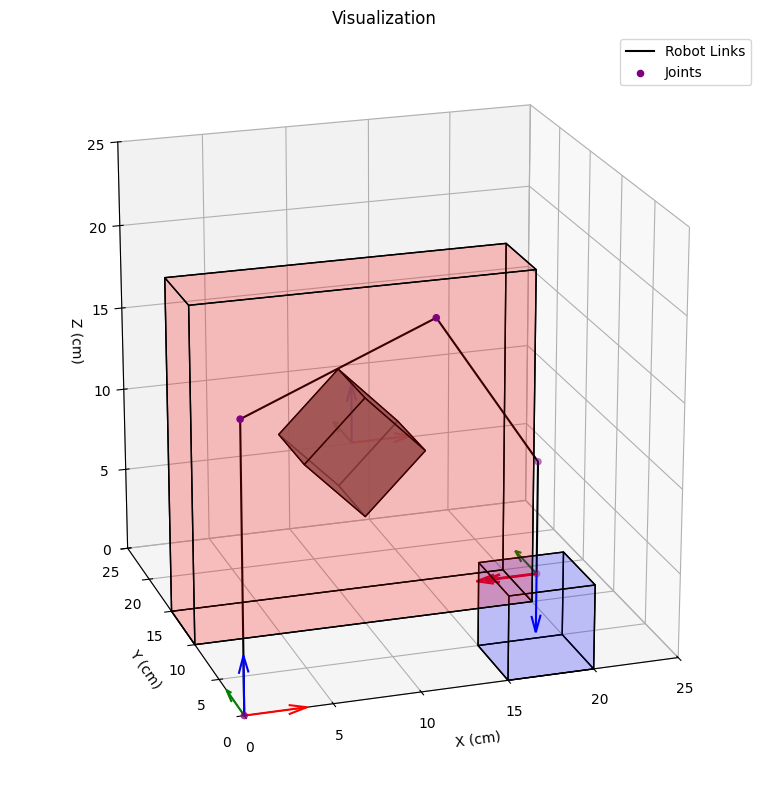

In [23]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# --- Red box (target big box) in cm ---
length_cm_r = 20; width_cm_r = 5; height_cm_r = 20
box_translation_r = np.array([0, 10, 0])
vertices_r_local = np.array([
    [0, 0, 0], [length_cm_r, 0, 0], [length_cm_r, width_cm_r, 0], [0, width_cm_r, 0],
    [0, 0, height_cm_r], [length_cm_r, 0, height_cm_r],
    [length_cm_r, width_cm_r, height_cm_r], [0, width_cm_r, height_cm_r]
])
vertices_r_world = vertices_r_local + box_translation_r
faces_r = [
    [vertices_r_world[0], vertices_r_world[1], vertices_r_world[2], vertices_r_world[3]],
    [vertices_r_world[4], vertices_r_world[5], vertices_r_world[6], vertices_r_world[7]],
    [vertices_r_world[0], vertices_r_world[1], vertices_r_world[5], vertices_r_world[4]],
    [vertices_r_world[2], vertices_r_world[3], vertices_r_world[7], vertices_r_world[6]],
    [vertices_r_world[1], vertices_r_world[2], vertices_r_world[6], vertices_r_world[5]],
    [vertices_r_world[0], vertices_r_world[3], vertices_r_world[7], vertices_r_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_r, facecolors='r', linewidths=1, edgecolors='k', alpha = 0.12))

# --- Blue cube (tool) in cm ---
length_cm_b = 5; width_cm_b = 5; height_cm_b = 5
box_translation_b = np.array([15, 0, 0])
vertices_b_local = np.array([
    [0, 0, 0], [length_cm_b, 0, 0], [length_cm_b, width_cm_b, 0], [0, width_cm_b, 0],
    [0, 0, height_cm_b], [length_cm_b, 0, height_cm_b],
    [length_cm_b, width_cm_b, height_cm_b], [0, width_cm_b, height_cm_b]
])
vertices_b_world = vertices_b_local + box_translation_b
faces_b = [
    [vertices_b_world[0], vertices_b_world[1], vertices_b_world[2], vertices_b_world[3]],
    [vertices_b_world[4], vertices_b_world[5], vertices_b_world[6], vertices_b_world[7]],
    [vertices_b_world[0], vertices_b_world[1], vertices_b_world[5], vertices_b_world[4]],
    [vertices_b_world[2], vertices_b_world[3], vertices_b_world[7], vertices_b_world[6]],
    [vertices_b_world[1], vertices_b_world[2], vertices_b_world[6], vertices_b_world[5]],
    [vertices_b_world[0], vertices_b_world[3], vertices_b_world[7], vertices_b_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_b, facecolors='b', linewidths=1, edgecolors='k', alpha = 0.12))

# --- Rhombus (rotated cube) in cm ---
side_length_h = 5.0
h = side_length_h / 2.0
vertices_h_local = np.array([
    [-h, -h, -h], [h, -h, -h], [h, h, -h], [-h, h, -h],
    [-h, -h, h], [h, -h, h], [h, h, h], [-h, h, h]
])
vertices_h_world_list = []
for v_local in vertices_h_local:
    v_local_col = v_local.reshape(3,1)
    v_world = transform_point_homogeneous(T_rhombus, v_local_col)
    vertices_h_world_list.append(v_world.flatten())
vertices_h_world = np.array(vertices_h_world_list)
faces_h = [
    [vertices_h_world[0], vertices_h_world[1], vertices_h_world[2], vertices_h_world[3]],
    [vertices_h_world[4], vertices_h_world[5], vertices_h_world[6], vertices_h_world[7]],
    [vertices_h_world[0], vertices_h_world[1], vertices_h_world[5], vertices_h_world[4]],
    [vertices_h_world[2], vertices_h_world[3], vertices_h_world[7], vertices_h_world[6]],
    [vertices_h_world[1], vertices_h_world[2], vertices_h_world[6], vertices_h_world[5]],
    [vertices_h_world[0], vertices_h_world[3], vertices_h_world[7], vertices_h_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_h, facecolors=[0.5,0.4,0.4], linewidths=1, edgecolors='k', alpha=0.7))

# --- Plot frames ---
plot_frame(ax, np.eye(4), size=3.5)  # world (cm) - Τώρα με βέλη
plot_frame(ax, Tbody2, size=3.5)     # red box frame - Τώρα με βέλη
plot_frame(ax, Tendef, size=3.5)     # EE frame - Τώρα με βέλη

# --- Plot robot skeleton ---
xs = skeleton_cm[:, 0]
ys = skeleton_cm[:, 1]
zs = skeleton_cm[:, 2]

# 1. Black lines for links
ax.plot(xs, ys, zs, color='black', linewidth=1.5, label='Robot Links')

# 2. Scatter for joints
ax.scatter(xs, ys, zs, color='purple', s=20, zorder=10, label='Joints')

# --- Draw arrow from EE tip ---
ee_pos_cm = Tendef[:3,3].flatten()
ee_dir = Tendef[:3,0]
arrow_len = 3.0
ax.quiver(ee_pos_cm[0], ee_pos_cm[1], ee_pos_cm[2],
          ee_dir[0], ee_dir[1], ee_dir[2],
          length=arrow_len, normalize=True, color='r', linewidth=2)

# Labels, limits, aspect
ax.set_xlabel('X (cm)'); ax.set_ylabel('Y (cm)'); ax.set_zlabel('Z (cm)')
ax.set_xlim([0,25]); ax.set_ylim([0,25]); ax.set_zlim([0,25])
ax.set_box_aspect([1,1,1])
ax.view_init(elev=20, azim=-108)
ax.set_title('Visualization')
plt.legend()

plt.tight_layout()
plt.show()

--- Σχετικός Μετασχηματισμός T_EC (Στόχος ως προς End-Effector) ---
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


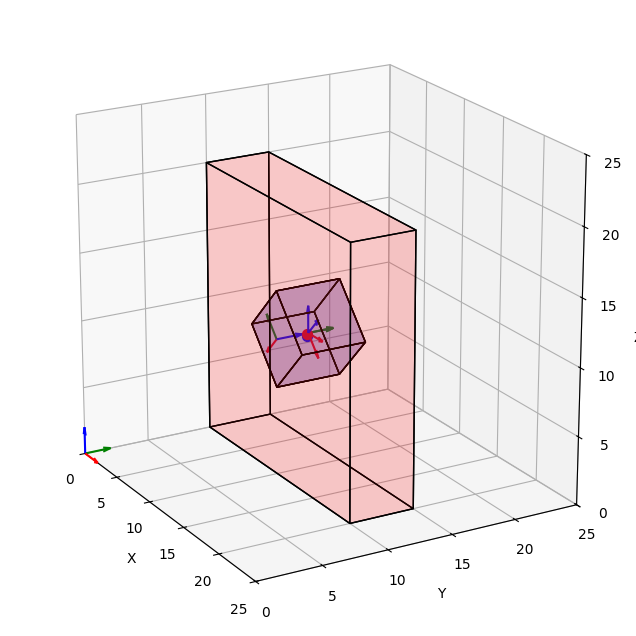

In [30]:
# --- Ορισμός Frames Αντικειμένων ---

# Tbody1: Frame για το μπλε κουτί (κέντρο)
Tbody1_translation = np.array([[10., 12.5, 10.]]).T # X=10, Z=10 (κέντρο τρύπας), Y=7.5 (ακριβώς έξω)
Tbody1_rotation = RotY(np.deg2rad(45)) # Ίδια περιστροφή με την τρύπα
Tbody1 = homogeneous(Tbody1_rotation, Tbody1_translation)


# Tbody2: Frame στο κέντρο του κόκκινου κουτιού (ΔΕΝ περιστρέφεται)
Tbody2_translation = np.array([[10., 12.5, 10]]).T
Tbody2 = homogeneous(RotY(0), Tbody2_translation) # Μηδενική περιστροφή

# T_rhombus: Ένας ξεχωριστός, "αόρατος" πίνακας ΜΟΝΟ για τον ρόμβο,
# ο οποίος ΕΧΕΙ την περιστροφή 45 μοιρών.
T_rhombus = homogeneous(RotY(np.deg2rad(45)), Tbody2_translation)


# --- Ρύθμιση 3D Γραφήματος ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# --- Κόκκινο Αντικείμενο (Κουτί-Στόχος) ---
length_cm_r = 20  # x
width_cm_r = 5   # y
height_cm_r = 20  # z
box_translation_r = np.array([0, 10, 0])
vertices_r_local = np.array([
    [0, 0, 0], [length_cm_r, 0, 0], [length_cm_r, width_cm_r, 0], [0, width_cm_r, 0],
    [0, 0, height_cm_r], [length_cm_r, 0, height_cm_r],
    [length_cm_r, width_cm_r, height_cm_r], [0, width_cm_r, height_cm_r]
])
vertices_r_world = vertices_r_local + box_translation_r
faces_r = [
    [vertices_r_world[0], vertices_r_world[1], vertices_r_world[2], vertices_r_world[3]],
    [vertices_r_world[4], vertices_r_world[5], vertices_r_world[6], vertices_r_world[7]],
    [vertices_r_world[0], vertices_r_world[1], vertices_r_world[5], vertices_r_world[4]],
    [vertices_r_world[2], vertices_r_world[3], vertices_r_world[7], vertices_r_world[6]],
    [vertices_r_world[1], vertices_r_world[2], vertices_r_world[6], vertices_r_world[5]],
    [vertices_r_world[0], vertices_r_world[3], vertices_r_world[7], vertices_r_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_r, facecolors='r', linewidths=1, edgecolors='k', alpha = 0.1))

# --- Μπλε Αντικείμενο (Κύβος-Εργαλείο) ---
# Ο ορισμός του (τοπικές κορυφές) παραμένει ο ίδιος
length_cm_b = 5
width_cm_b = 5
height_cm_b = 5
h_b = length_cm_b / 2.0 # Θα το κεντράρουμε στο 0,0,0 για ευκολία

# Ορίζουμε τις κορυφές τοπικά γύρω από το (0,0,0)
vertices_b_local = np.array([
    [-h_b, -h_b, -h_b], [h_b, -h_b, -h_b], [h_b, h_b, -h_b], [-h_b, h_b, -h_b],
    [-h_b, -h_b, h_b], [h_b, -h_b, h_b], [h_b, h_b, h_b], [-h_b, h_b, h_b]
])

# Μετασχηματίζουμε τις κορυφές του μπλε κουτιού με το Tbody1
vertices_b_world_list = []
for v_local in vertices_b_local:
    v_world = transform_point_homogeneous(Tbody1, v_local.reshape(3,1))
    vertices_b_world_list.append(v_world.flatten())
vertices_b_world = np.array(vertices_b_world_list)

# Ορίζουμε τις 6 όψεις
faces_b = [
    [vertices_b_world[0], vertices_b_world[1], vertices_b_world[2], vertices_b_world[3]],
    [vertices_b_world[4], vertices_b_world[5], vertices_b_world[6], vertices_b_world[7]],
    [vertices_b_world[0], vertices_b_world[1], vertices_b_world[5], vertices_b_world[4]],
    [vertices_b_world[2], vertices_b_world[3], vertices_b_world[7], vertices_b_world[6]],
    [vertices_b_world[1], vertices_b_world[2], vertices_b_world[6], vertices_b_world[5]],
    [vertices_b_world[0], vertices_b_world[3], vertices_b_world[7], vertices_b_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_b, facecolors='b', linewidths=1, edgecolors='k', alpha = 0.1))


# --- Ρόμβος (Περιστραμμένος Κύβος) ---
side_length_h = 5.0
h = side_length_h / 2.0
vertices_h_local = np.array([
    [-h, -h, -h], [h, -h, -h], [h, h, -h], [-h, h, -h],
    [-h, -h, h], [h, -h, h], [h, h, h], [-h, h, h]
])

vertices_h_world_list = []
for v_local in vertices_h_local:
    v_local_col = v_local.reshape(3, 1)
    # Χρησιμοποιούμε τον T_rhombus (τον περιστραμμένο)
    v_world = transform_point_homogeneous(T_rhombus, v_local_col)
    vertices_h_world_list.append(v_world.flatten())

vertices_h_world = np.array(vertices_h_world_list)
faces_h = [
    [vertices_h_world[0], vertices_h_world[1], vertices_h_world[2], vertices_h_world[3]],
    [vertices_h_world[4], vertices_h_world[5], vertices_h_world[6], vertices_h_world[7]],
    [vertices_h_world[0], vertices_h_world[1], vertices_h_world[5], vertices_h_world[4]],
    [vertices_h_world[2], vertices_h_world[3], vertices_h_world[7], vertices_h_world[6]],
    [vertices_h_world[1], vertices_h_world[2], vertices_h_world[6], vertices_h_world[5]],
    [vertices_h_world[0], vertices_h_world[3], vertices_h_world[7], vertices_h_world[4]]
]
ax.add_collection3d(Poly3DCollection(faces_h, facecolors=[0.5, 0.4, 0.4], linewidths=1, edgecolors='k', alpha=0.1))


# --- Σχεδίαση Frames ---
plot_frame(ax, np.eye(4)) # World Frame {S}
# Το Tbody1 θα είναι τώρα περιστραμμένο και μπροστά από την τρύπα
plot_frame(ax, Tbody1) # Frame Μπλε Κουτιού {B1}
plot_frame(ax, Tbody2) # Frame Κόκκινου Κουτιού {B2} (ευθυγραμμισμένο)

# --- Μετασχηματισμός Σημείου ---
pb = np.array([[0.2, -0.2, 0.]]).T
pw = transform_point_homogeneous(Tbody1, pb)
ax.scatter(pw[0], pw[1], pw[2], c='b', s=50, label='pb xform from Blue')

pw2 = transform_point_homogeneous(Tbody2, pb)
ax.scatter(pw2[0], pw2[1], pw2[2], c='r', s=50, label='pb xform from Red')

# T_SE: Η πόζα του End-Effector (μπλε κουτί) ως προς τον Κόσμο {S}
T_SE = Tbody1

# T_SC: Η πόζα του Cube (στόχος/ρόμβος) ως προς τον Κόσμο {S}
T_SC = T_rhombus

# T_ES: Ο αντίστροφος του T_SE. Περιγράφει τον Κόσμο {S} ως προς το {E}
T_ES = np.linalg.inv(T_SE)

# T_EC: Η πόζα του Cube {C} ως προς τον End-Effector {E}
# T_EC = T_ES @ T_SC
T_EC = np.dot(T_ES, T_SC) # Ίδιο με το @

# Εκτύπωση του αποτελέσματος
print("--- Σχετικός Μετασχηματισμός T_EC (Στόχος ως προς End-Effector) ---")
np.set_printoptions(precision=3, suppress=True)
print(T_EC)
pendef = np.array([[10., 10., 10.]]).T
Rendef = RotX(np.deg2rad(270)) @ RotY(np.deg2rad(0)) @ RotZ(np.deg2rad(135))
Tendef = homogeneous(Rendef, pendef)
plot_frame(ax, Tendef)
# --- Τελικές Ρυθμίσεις Γραφήματος ---
ax.set_xlim([0,25])
ax.set_ylim([0,25])
ax.set_zlim([0,25])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=20, azim=-30)

plt.show()